# Инструкция по запуску
* Запускать все ячейки поочередно
* Ячейки с обучением долго работают, поэтому оставила результаты в аутпуте. Я предупрежу, когда начнутся долгие ячейки :) 
* Для отображения картинок нужно поменять переменную **show_images** на True в ячейке ниже

In [207]:
show_images = False

In [54]:
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from matplotlib import image 
import random
import IPython.display as Disp

import time
import aiohttp
import asyncio

from io import BytesIO
import requests
import numpy as np 
from PIL import Image

In [184]:
import cv2
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from torch import nn
import torch.optim as optim
import torch.nn.functional as F

import torch

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from abc import ABC, abstractmethod

# Подготовка данных

## Импорт

In [3]:
df_geog = pd.read_csv('georges.csv', header=None)
df_notgeog = pd.read_csv('non_georges.csv', header=None)

In [4]:
df_geog_ = df_geog.copy()
df_geog_['target'] = 1
df_notgeog_ = df_notgeog.copy()
df_notgeog_['target'] = 0


df_full = pd.concat([df_geog_, df_notgeog_], ignore_index=True)
df_full.rename(columns={0:'url', 'target': 'target'}, inplace=True)

In [5]:
display(df_full.head())
df_full.shape

,url,target
0,https://i.pinimg.com/736x/17/0d/5b/170d5b93d80...,1
1,https://i.pinimg.com/736x/47/b9/9a/47b99a2ddcd...,1
2,https://i.pinimg.com/736x/90/e8/90/90e890f054b...,1
3,https://i.pinimg.com/736x/0a/71/6f/0a716f6f14e...,1
4,https://i.pinimg.com/736x/f1/95/be/f195bea0b78...,1


(6047, 2)

## Разведывательный анализ :)

### 1. Что мы вообще загрузили

In [6]:
display(df_geog.head()) 

df_geog.shape, df_notgeog.shape

,0
0,https://i.pinimg.com/736x/17/0d/5b/170d5b93d80...
1,https://i.pinimg.com/736x/47/b9/9a/47b99a2ddcd...
2,https://i.pinimg.com/736x/90/e8/90/90e890f054b...
3,https://i.pinimg.com/736x/0a/71/6f/0a716f6f14e...
4,https://i.pinimg.com/736x/f1/95/be/f195bea0b78...


((2681, 1), (3366, 1))

In [7]:
df_geog.iloc[0,0]

'https://i.pinimg.com/736x/17/0d/5b/170d5b93d80d247be60f22ca1216bef7.jpg'

Вспомогательные функции для загрузки изображений

In [57]:
def load_image(url): 
    res = requests.get(url)
    if res.status_code == 200 and 'jpeg' in res.headers['content-type']:
        img_arr = np.array(Image.open(BytesIO(res.content)))
        return  img_arr
    else: 
        return  np.array([])

In [218]:
async def async_load_image(res, i, save_to_file=False, folder=''): 
    img = Image.open(BytesIO(await res.content.read()))
    
    if save_to_file:
        img.save(folder + 'img' + str(i) + '.jpeg')    
        
    img_arr = np.array(img)
    return img_arr

In [209]:
plt.imshow(load_image(df_geog.iloc[0,0]))
plt.show()
plt.imshow(load_image(df_notgeog.iloc[0,0]))
plt.show()

if not show_images:
    Disp.clear_output()

Ага, у нас тут картинки, и картинки разного размера. Посмотрим, какие размеры вообще представлены.

### Анализ содержимого

In [59]:
async def fetch_img(session, url, i, save_to_file):
    async with session.get(url) as response:
        if response.status != 200:
            response.raise_for_status()
        return await async_load_image(response, i, save_to_file)

async def fetch_img_all(session, urls, save_to_file):
    tasks = []
    for i, url in enumerate(urls):
        task = asyncio.create_task(fetch_img(session, url, i, save_to_file))
        tasks.append(task)
    results = await asyncio.gather(*tasks)
    return results

async def loader_main(urls, save_to_file):    
    async with aiohttp.ClientSession() as session:
        htmls = await fetch_img_all(session, urls, save_to_file)
#         print(htmls)
    return htmls

In [60]:
print('Processing...')
start = time.time()

urls = list(df_full['url'])
img_list = await loader_main(urls, save_to_file=False)

print('Seconds elapsed: ', round(time.time() - start, 2))
# asyncio.run(main())

Processing...
Seconds elapsed:  78.05


In [212]:
not_colorful = [ind for ind, img in enumerate(img_list) if len(img.shape) < 3]
alpha_ch = [ind for ind, img in enumerate(img_list) if (len(img.shape) == 3)&(img.shape[-1] > 3)]

print('Не цветные: ', len(not_colorful), '\nС альфа-каналом: ', len(alpha_ch))

Не цветные:  46 
С альфа-каналом:  3


In [215]:
plt.imshow(img_list[not_colorful[0]])
plt.show()
plt.imshow(img_list[alpha_ch[0]])
plt.show()
if not show_images:
    Disp.clear_output()

Хорошо, это нам сейчас не нужно, мы хотим оценить размеры

In [66]:
df_full['hight'] = np.array([i.shape[0] for i in img_list])
df_full['width'] = np.array([i.shape[1] for i in img_list])
df_full['relation'] = df_full['width']/df_full['hight']

,target,hight,width,relation
count,6047.000000,6047.000000,6047.000000,6047.000000
mean,0.443360,732.870184,549.738713,0.801997
std,0.496823,290.386326,165.446069,0.271161
min,0.000000,110.000000,120.000000,0.127138
25%,0.000000,538.000000,422.000000,0.666667
50%,0.000000,700.000000,564.000000,0.736000
75%,1.000000,935.000000,736.000000,0.833333
max,1.000000,5789.000000,736.000000,4.515337


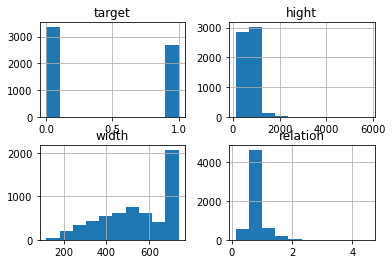

In [67]:
display(df_full.describe())
df_full.hist()
plt.show()

Смотрим странные случаи

In [216]:
strange_image_index = df_full[df_full['relation'] > 4].index[0]
plt.imshow(img_list[strange_image_index])
plt.title(str(strange_image_index))
plt.show()
if not show_images:
    Disp.clear_output()

In [217]:
strange_image_index = df_full[df_full['hight'] == 5789].index[0]
plt.imshow(img_list[strange_image_index])
plt.title(str(strange_image_index))
plt.show()
if not show_images:
    Disp.clear_output()

# Обучение

## Типы для трансформации и классификации

In [73]:
class ImageTransformer(TransformerMixin, ABC):
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        new_X = []
        for x in X:
            new_X.append(self.transform_one(x, y))
        
        return new_X
    
    @abstractmethod
    def transform_one(self, X, y=None, **fit_params):
        pass


class BlurImageTransformer(ImageTransformer):
    def __init__(self, blur_method=cv2.GaussianBlur, blur_kernel=(5, 5) ):
        self.blur_method = blur_method
        self.blur_kernel = blur_kernel
      
    def transform_one(self, X, y=None, **fit_params):
        return self.blur_method(X, self.blur_kernel)
    
    
class SegmetationImageTransformer(ImageTransformer):
    def transform_one(self, X, y=None, **fit_params):
        gray = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
        
        ret, thresh = cv2.threshold(gray, 0, 255, 
                                    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, 
                                   kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        
        unknown = cv2.subtract(sure_bg, sure_fg)
        
        ret, markers = cv2.connectedComponents(sure_fg)
        
        markers = markers + 1
        markers[unknown == 255] = 0

        markers = cv2.watershed(X, markers)
        X[markers == -1] = [0, 0, 0]
        
        return X
    
    
class ReshapeImageTransformer(ImageTransformer):
    def __init__(self, chosen_shape=(150, 150)):
        self.chosen_shape = chosen_shape
    
    def transform_one(self, X, y=None, **fit_params): 
        X = cv2.resize(X, self.chosen_shape)
       
        return X
    

class FilterImageTransformer(ImageTransformer):
    def __init__(self, filter_arr=def_filter_arr):
        self.filter_arr = filter_arr
    
    def transform_one(self, X, y=None, **fit_params):
        X = cv2.filter2D(X, -1, self.filter_arr)
        
        return X
    

class GrayImageTransformer(ImageTransformer):
    def transform_one(self, X, y=None, **fit_params):
        X = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)

        return X
    
class ScalerImageTransformer(ImageTransformer):
    def __init__(self, is_flatten=True):
        self.is_flatten = is_flatten
        
    def transform(self, X, y=None, **fit_params):
        if self.is_flatten:
            X = np.array([i.flatten() for i in X])
        else:
            X = np.array([i for i in X])

        X = X/255
        
        return X
    
    def transform_one(self, X, y=None, **fit_params):
        pass
    
    
class FlipperImageTransformer(ImageTransformer):
    def transform(self, X, y=None, **fit_params):
        res_0 = []
        res_1 = []
        for x in X:
            res_0.append(cv2.flip(x, 0))
            res_1.append(cv2.flip(x, 1))
            
        X.extend(res_0)
        X.extend(res_1)
        
        return X
    
    
    def transform_one(self, X, y=None, **fit_params):
        pass
    
class TransformerCombiner:
    @classmethod
    def process_step(cls, X, y, step, verbose, i, n):
        if verbose:
            print(f'Transformation {i} of {n}, step {step[0]}')
            
        return step[1].fit_transform(X, y)
    
    
    @classmethod
    def fit_transform(cls, X, y, steps, verbose=False):
        for i, step in enumerate(steps):
            X = cls.process_step(X, y, step, verbose, i, len(steps))
            
        return X

In [198]:
class ConvNet(nn.Module):
    def __init__(self, input_shape, kernel_size=3, out_channel=6, *args):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(input_shape[0], out_channel, kernel_size)
        self.pool1 = nn.MaxPool2d(3, 3)
        
        self.dropout1 = nn.Dropout(0.2)
        
        n_inp = self.get_linear_layer_inp_shape(input_shape, kernel_size, out_channel)
        
        self.fc1 = nn.Linear(n_inp, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 16)
        self.dropout3 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(16, 1)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = x.view(-1, self.get_num_features(x))
        x = self.dropout1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = torch.tanh(self.fc2(x))
        x = self.dropout3(x)
        x = torch.sigmoid(self.fc3(x))
        x = torch.flatten(x)
        return x
    
    
    def get_num_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    
    def get_linear_layer_inp_shape(self, input_shape, kernel_size, out_channel):
        print()
        return (input_shape[1]//kernel_size - 1) * (input_shape[2]//kernel_size - 1) * out_channel

In [138]:
#для поддержки интерфейса scikit-learn
class CNNClassifier(BaseEstimator):
    def __init__(self, input_shape, n_iter, n_epoch, criterion, sens=0.5, 
                 batch_size=4, kernel_size=3, out_channel=6):
        
        super(CNNClassifier, self).__init__()
        
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.out_channel = out_channel
        
        self.net = ConvNet(self.input_shape, self.kernel_size, self.out_channel)
        
        self.n_iter = n_iter
        self.n_epoch = n_epoch
        
        self.criterion = criterion
        self.optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        
        self.sens = sens
        self.batch_size = batch_size
        
        
    def transform_input_data(self, X, y=None):
        inputs = torch.tensor(X) 
        
        if not (y is None):
            labels = torch.tensor(y)
        else:
            labels = None
            
        inputs = inputs.unsqueeze(1).float()
        
        return inputs, labels
        
        
    def fit(self, X, y):
        inputs, labels = self.transform_input_data(X, y)
        
        for epoch in range(self.n_epoch):
            
            permutation = torch.randperm(inputs.size()[0])
            
            for i in range(0, inputs.size()[0], self.batch_size):
                indices = permutation[i:i+self.batch_size]
                batch_x, batch_y = inputs[indices], labels[indices]


                for k in range(self.n_iter):

                    self.optimizer.zero_grad()
                    outputs = self.net(batch_x)
                    loss = self.criterion(outputs.float(), batch_y.float())
                    loss.backward()

                    self.optimizer.step()

                    # print statistics
                    loss = loss.item()
                    
                if i % 1000 == 0: 
                    outputs_ = self.net(inputs)
                    y_pred = np.where(outputs_ > self.sens, 1, 0)
                    accuracy = accuracy_score(y_pred, y)
                    print(f'Epoch: {epoch}, iter: {i}, accuracy: {accuracy}')

        print('Finished Training')
        
        
    def predict(self, X):
        inputs, _ = self.transform_input_data(X)
        outputs = self.net(inputs)
        
        return np.where(outputs > self.sens, 1, 0)

## Транформация данных

In [84]:
chosen_shape = (51, 51)
blur_kernel = (3, 3)
def_filter_arr = np.array(
    [
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ]
)
george_max_index = max(df_full[df_full['target'] == 1].index)

In [85]:
blurer = BlurImageTransformer(blur_method=cv2.GaussianBlur, blur_kernel=(5, 5) )
segmetator = SegmetationImageTransformer()
reshaper = ReshapeImageTransformer(chosen_shape=chosen_shape)
filterer = FilterImageTransformer(filter_arr=def_filter_arr)
grayer = GrayImageTransformer()
flipper = FlipperImageTransformer()
scaler = ScalerImageTransformer(is_flatten=True)
scaler_t = ScalerImageTransformer(is_flatten=False)

In [169]:
y = np.array([1 if i <= george_max_index else 0 for i in range(df_full.shape[0])])
colorful_img_list = [cv2.cvtColor(i,cv2.COLOR_GRAY2RGB) if len(i.shape) < 3 else 
                     (cv2.cvtColor(i,cv2.COLOR_BGRA2BGR) if i.shape[2] > 3 else i) 
                     for i in img_list]

Для начала рассматриваем базовую трансформацию:
* Приводим к одному размеру
* Оставляем один канал (оттенки серого)
* Нормируем

In [95]:
X = TransformerCombiner.fit_transform(colorful_img_list, 
                                       y, 
                                       [('reshaper', reshaper), 
                                        ('grayer', grayer), ('scaler', scaler)],
                                       True)
X.shape

Transformation 0 of 3, step reshaper
Transformation 1 of 3, step grayer
Transformation 2 of 3, step scaler


(6047, 2601)

In [96]:
X_t = TransformerCombiner.fit_transform(colorful_img_list, y, 
                                       [('reshaper', reshaper), 
                                        ('grayer', grayer), ('scaler', scaler_t)],
                                       True)
X_t.shape

Transformation 0 of 3, step reshaper
Transformation 1 of 3, step grayer
Transformation 2 of 3, step scaler


(6047, 51, 51)

Так как у нас пока нет зависимости между объектами (отраженных изображений или вырезенных элементов), значит мы можем произвольно разделить их на dev-выборку и валидационную (1/8 всех объектов).

Dev-выборку будем использовать для настройки параметров, а валидационную - для оценки и выбора модели

In [111]:
strat_kfold = StratifiedKFold(n_splits=8, random_state=1)

cv = strat_kfold.split(X_, y)
dev_ind, val_ind = next(cv)

X_dev = X[dev_ind]
X_dev_t = X_t[dev_ind]
X_val = X[val_ind]
X_val_t = X_t[val_ind]

y_dev = y[dev_ind]
y_val = y[val_ind]

X_dev.shape, y_dev.shape

((5291, 2601), (5291,))

## Настройка гиперпараметров у моделей

### ВНИМАНИЕ! Начинаются долкие ячейки :) 

Для начала найдем оптимальные гиперпараметры для всех кандидатов в классификаторы. Т.к. нейронная сеть обучается долго, то для нее я не буду настраивать гипер-параметры. Но возможность этого оставила :) 

In [201]:
model_grid_list = {
    'LogReg': ( LogisticRegression(), {
       'max_iter': [5000, 10000],
       'C':np.logspace(-3,3,7)
    } ),
    'SVM': ( SVC(), {
        'C': [1, 10, 100, 1000], 
        'gamma': [0.001, 0.0001, 'auto'], 
        'kernel': ['rbf']
    } ),
    'kN': ( KNeighborsClassifier(), {
        'n_neighbors': [1, 2, 3],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    } ),
    'MLP': ( MLPClassifier(max_iter=5000), {
        'hidden_layer_sizes': [(100,), (100, 100), (20, 40, 20)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.005, 0.1]
    } ),
    'cNN': ( CNNClassifier((1, *(X_dev_t.shape[1:])), 1000, 4, nn.MSELoss(), batch_size=10), {
        'batch_size': [200]
    } )
}

In [151]:
def tune_and_assess_models(X, y, model_grid_list, cv_split=3, models_exclude=[]):
    gs_dict = {}
    
    for model_name, model in model_grid_list.items():
        
        if model_name not in models_exclude:
            print(f'Processing {model_name}')
            
            strat_kfold = StratifiedKFold(n_splits=cv_split, shuffle=True, random_state=2)
            cv = strat_kfold.split(X, y)
            gs_dict[model_name] = GridSearchCV(*(model), verbose=True, cv=cv, scoring='accuracy') 
            gs_dict[model_name].fit(X, y)
            
            print(f'Model {model_name}, score: {gs_dict[model_name].best_score_}')
        else:
            print(f'Model {model_name} is excluded!')
            
    return gs_dict

In [153]:
gs_dict = tune_and_assess_models(X_dev, y_dev, model_grid_list, models_exclude=['cNN'])

Processing LogReg
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Model LogReg, score: 0.6773768686903766
Processing SVM
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Model SVM, score: 0.7187663052868466
Processing kN
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Model kN, score: 0.6924933835637992
Processing MLP
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Model MLP, score: 0.7233026316974133
Model cNN is excluded!


In [152]:
gs_dict_cnn = tune_and_assess_models(X_dev_t, y_dev, model_grid_list, 
                                     models_exclude=[i for i in model_grid_list.keys() if i != 'cNN'])

Model LogReg is excluded!
Model SVM is excluded!
Model kN is excluded!
Model MLP is excluded!
Processing cNN

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Epoch: 0, iter: 0, accuracy: 0.5817975616671393
Epoch: 0, iter: 1000, accuracy: 0.7258293166997448
Epoch: 0, iter: 2000, accuracy: 0.7692089594556281
Epoch: 0, iter: 3000, accuracy: 0.8134391834420187
Epoch: 1, iter: 0, accuracy: 0.8219449957470939
Epoch: 1, iter: 1000, accuracy: 0.8403742557414233
Epoch: 1, iter: 2000, accuracy: 0.8627728948114545
Epoch: 1, iter: 3000, accuracy: 0.8962290898780834
Epoch: 2, iter: 0, accuracy: 0.905585483413666
Epoch: 2, iter: 1000, accuracy: 0.9254323787921747
Epoch: 2, iter: 2000, accuracy: 0.9325205557130706
Epoch: 2, iter: 3000, accuracy: 0.9506662886305642
Epoch: 3, iter: 0, accuracy: 0.9614403175503261
Epoch: 3, iter: 1000, accuracy: 0.9634250070881769
Epoch: 3, iter: 2000, accuracy: 0.9662602778565353
Epoch: 3, iter: 3000, accuracy: 0.9744825630847745
Finished Training

Epoch: 0

На кросс-валидации сверточная нейронная сеть показывает наилучший результат (без настройки гипер-параметров)

Есть вероятность, что использование дополнительной подготовки данных улучшит результат nonDL модели. Попробуем выбрать наилучший пайплайн для подготовки данных для каждой из них

In [154]:
def get_best_model(gs_result):
    best_estimator = None
    best_score = 0
    for model_name, gs in gs_result.items():
        if gs.best_score_ > best_score:
            best_estimator = gs.best_estimator_
            best_score = gs.best_score_
            best_model = model_name
            
    return best_estimator, best_score, best_model


def get_preprocessing_pipeline_score(estimator, pipeline_list, img_list, y, cv_split=3):
    
    n_objects = len(img_list)
    
    acc = {}
    for pl_name, pl in pipeline_list.items():
        print(f'Processing {pl_name}...')
        X_ = TransformerCombiner.fit_transform(img_list, y, pl)
        y_ = np.array(list(y)*(X_.shape[0]//n_objects))
        
        group_kfold = GroupKFold(n_splits=cv_split)
        groups = np.array([i % (n_objects) for i in range(X_.shape[0])])

        cv = group_kfold.split(X_, y_, groups)
        
        acc[pl_name] = cross_val_score(estimator, X_, y_, cv=cv, 
                                   scoring='accuracy')
        
        
        print(f'Pipeline {pl_name}, score: {acc[pl_name].mean()}')
    
    return acc

In [173]:
steps_dict = {
    'baseline': [('reshaper', reshaper), ('grayer', grayer), ('scaler', scaler)],
    'simple': [('reshaper', reshaper), ('grayer', grayer), ('flipper', flipper), ('scaler', scaler)],
    'filter': [('reshaper', reshaper), ('filter', filterer), ('grayer', grayer), ('flipper', flipper), 
               ('scaler', scaler)],
    'segmentation': [('reshaper', reshaper), ('segmetator', segmetator), 
                     ('grayer', grayer), ('flipper', flipper), ('scaler', scaler)],
    'segm+filter': [('reshaper', reshaper), ('filter', filterer), ('segmetator', segmetator), 
                     ('grayer', grayer), ('flipper', flipper), ('scaler', scaler)]
}

In [175]:
for model_name, gs in gs_dict.items():
    print(f'Model {model_name}')
    best_estimator = gs.best_estimator_
    scoring = get_preprocessing_pipeline_score(
                                        best_estimator,
                                        steps_dict,
                                        [img for i, img in enumerate(colorful_img_list) if i in dev_ind], 
                                        y_dev
                                    )
    print(f'Model {model_name} comleted\n')

Model LogReg
Processing baseline...
Pipeline baseline, score: 0.6788902994234816
Processing simple...
Pipeline simple, score: 0.6543209519264944
Processing filter...
Pipeline filter, score: 0.6448067031690724
Processing segmentation...
Pipeline segmentation, score: 0.6422877484852474
Processing segm+filter...
Pipeline segm+filter, score: 0.6366800517396093
Model LogReg comleted

Model SVM
Processing baseline...
Pipeline baseline, score: 0.7168800904114088
Processing simple...
Pipeline simple, score: 0.7129752890631265
Processing filter...
Pipeline filter, score: 0.7100755472038188
Processing segmentation...
Pipeline segmentation, score: 0.6940116732813165
Processing segm+filter...
Pipeline segm+filter, score: 0.683993483530258
Model SVM comleted

Model kN
Processing baseline...
Pipeline baseline, score: 0.7064844719005646
Processing simple...
Pipeline simple, score: 0.6885284880112419
Processing filter...
Pipeline filter, score: 0.6771226652043981
Processing segmentation...
Pipeline se

Все придуманные предобработки не показали себя хорошо на кросс-валидации. Поэтому для финальной модели будет использоваться бэйзлайновый пайплайн подготовки данных

# Оценка точности моделей и выбор лучшей

_Примечание_: на самом деле, так как здесь я не настраивала параметры для сверточной нейронной сети, то риска переобучиться при настройке параметров у нас нет, а, так как даже без настройки гипер-параметров cNN показала себя лучше, чем классический модели и персептрон, то она является более предпочтительной. 

Однако, для честности, представим, что cNN мы тоже настраивали, а наш валидационный датасет достаточно велик, чтобы использовать его в качестве отложенной выборки для нешумной оценки качества моделей (что, конечно же, не так, когда речь идет про ~700 объектов)

### Scikit-learn стэк

In [193]:
accuracy = {}
for model_name, gs in gs_dict.items():
    print(f'Processing {model_name}')
    params = gs.best_params_
    
    best_estimator = model_grid_list[model_name][0].set_params(**params)
    best_estimator.fit(X_dev, y_dev)
    y_pred = best_estimator.predict(X_val)
    
    accuracy[model_name] = accuracy_score(y_val, y_pred)
    print(f'Model {model_name}, score {accuracy[model_name]}')    

Processing LogReg
Model LogReg, score 0.7261904761904762
Processing SVM
Model SVM, score 0.7738095238095238
Processing kN
Model kN, score 0.7579365079365079
Processing MLP
Model MLP, score 0.716931216931217


### cNN

In [202]:
for model_name, gs in gs_dict_cnn.items():
    print(f'Processing {model_name}')
    params = gs.best_params_
    
    best_estimator = model_grid_list[model_name][0].set_params(**params)
    best_estimator.fit(X_dev_t, y_dev)
    y_pred = best_estimator.predict(X_val_t)
    
    accuracy[model_name] = accuracy_score(y_val, y_pred)
    print(f'Model {model_name}, score {accuracy[model_name]}')

Processing cNN
Epoch: 0, iter: 0, accuracy: 0.5583065583065583
Epoch: 0, iter: 1000, accuracy: 0.6633906633906634
Epoch: 0, iter: 2000, accuracy: 0.6998676998676999
Epoch: 0, iter: 3000, accuracy: 0.7233037233037233
Epoch: 0, iter: 4000, accuracy: 0.7535437535437536
Epoch: 0, iter: 5000, accuracy: 0.7611037611037611
Epoch: 1, iter: 0, accuracy: 0.766017766017766
Epoch: 1, iter: 1000, accuracy: 0.7852957852957853
Epoch: 1, iter: 2000, accuracy: 0.8217728217728217
Epoch: 1, iter: 3000, accuracy: 0.8223398223398224
Epoch: 1, iter: 4000, accuracy: 0.8476658476658476
Epoch: 1, iter: 5000, accuracy: 0.8365148365148365
Epoch: 2, iter: 0, accuracy: 0.8597618597618598
Epoch: 2, iter: 1000, accuracy: 0.879039879039879
Epoch: 2, iter: 2000, accuracy: 0.8848988848988849
Epoch: 2, iter: 3000, accuracy: 0.8862218862218862
Epoch: 2, iter: 4000, accuracy: 0.9020979020979021
Epoch: 2, iter: 5000, accuracy: 0.9124929124929125
Epoch: 3, iter: 0, accuracy: 0.9276129276129276
Epoch: 3, iter: 1000, accuracy

In [205]:
the_best_of_the_best = model_grid_list['cNN'][0]

# Результаты

Лучшая модель - **сверточная нейронная сеть** (даже не смотря на маленькую выборку)

Точность:
* на кросс-валидации: 75.1%
* на отложенной выборке: 81.1%


Имеет место сильное переобучение